In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import sparse, special, stats

# Machine Learning
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import catboost

# Parallel Processing
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

# Data Structure and Iteration
from collections import defaultdict
from itertools import combinations, permutations

# Visualization
import matplotlib.pyplot as plt

# System and Utilities
import os
import re
import random
import warnings
import contextlib
import itertools
from typing import List, Set, Dict, Tuple, Optional
import json

# Grove
import sys
sys.path.append('../src')
from grove_model import Grove_binary

# 데이터 불러오기 (VIQ 데이터)

In [2]:
# VIQ
url = 'https://github.com/novicedata/Paper/blob/main/Grove_CAT/data/VIQT_data.csv?raw=true'
data = pd.read_csv(url, sep = '\t')

In [3]:
data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,S26,S27,S28,S29,S30,education,urban,gender,engnat,age
0,24,3,10,24,9,-1,5,10,18,10,...,2,5,2,3,2,3,3,2,1,54
1,24,3,10,3,9,12,17,10,20,10,...,3,1,4,5,5,2,3,2,1,16
2,24,3,10,5,9,9,10,10,17,10,...,4,5,5,5,1,4,2,2,1,32
3,24,3,10,5,9,9,17,10,0,10,...,1,1,5,5,5,4,3,1,2,24
4,24,3,10,5,9,9,17,10,17,10,...,3,3,4,4,3,3,3,1,1,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12168,24,3,10,5,9,9,6,10,17,10,...,3,4,4,3,3,4,3,1,1,51
12169,24,3,10,5,9,9,17,10,17,10,...,1,5,2,3,5,2,3,1,1,33
12170,24,3,10,24,9,9,17,10,-1,10,...,2,4,3,3,4,3,2,2,1,40
12171,24,18,-1,-1,17,-1,3,18,9,0,...,2,2,5,5,3,3,3,1,2,28


# 데이터 정제

gender, age, NaN 처리

문항 칼럼만 남기고 code book에 있는 대로 정답키를 생성하여 적용, 점수 또한 code book에 있는 그대로 적용한 후 합격, 불합격자를 상위 30%를 기점으로 분류

In [4]:
#VIQ
print(f'raw : {data.shape}')

# gender가 3 또는 0인 행 제거
data.drop(data[(data['gender'] == 3) | (data['gender'] == 0)].index, inplace=True)

# age가 14세 미만 또는 80세 초과인 행 제거
data.drop(data[(data['age'] < 14) | (data['age'] > 80)].index, inplace=True)
print(f'After filtering gender and age: {data.shape}')

# NaN 행 제거
data.dropna(inplace=True)
print(f'After dropping NaN: {data.shape}')

# 필요한 컬럼만 남김 (Q1 ~ Q45)
data = data.iloc[:, 0:45]

# 정답 키 생성
answers = {
    'Q1': 24, 'Q2': 3, 'Q3': 10, 'Q4': 5, 'Q5': 9,
    'Q6': 9, 'Q7': 17, 'Q8': 10, 'Q9': 17, 'Q10': 10,
    'Q11': 5, 'Q12': 17, 'Q13': 9, 'Q14': 5, 'Q15': 18,
    'Q16': 18, 'Q17': 3, 'Q18': 12, 'Q19': 18, 'Q20': 18,
    'Q21': 3, 'Q22': 18, 'Q23': 6, 'Q24': 12, 'Q25': 17,
    'Q26': 10, 'Q27': 10, 'Q28': 9, 'Q29': 9, 'Q30': 3,
    'Q31': 6, 'Q32': 10, 'Q33': 17, 'Q34': 3, 'Q35': 17,
    'Q36': 24, 'Q37': 17, 'Q38': 5,
    'Q39': 5, 'Q40': 24, 'Q41': 5, 'Q42': 5, 'Q43': 12,
    'Q44': 10, 'Q45': 9
}

# 문제별 정답과 일치 여부를 1과 0으로 변환
for q, correct_answer in answers.items():
    data[q] = (data[q] == correct_answer).astype(int)

# score_right와 score_wrong 계산
data['score_right'] = data.iloc[:, :45].sum(axis=1)  # 맞춘 개수 (1의 합)
data['score_wrong'] = 45 - data['score_right']      # 틀린 개수 (전체 45개 중에서 맞춘 개수를 뺀 값)

# score_full 계산
data['score_full'] = data['score_right'] - 0.35 * data['score_wrong']
print(data['score_full'].quantile(0.70))

# score_full이 상위 30%인지 여부를 이진 변수로 변환
data['score_full'] = (data['score_full'] >= data['score_full'].quantile(0.70)).astype(int)

# X와 y 분리
X = data.iloc[:, 0:45]
y = data['score_full']

# 결과 확인
print(X.head())
print(y.head())


raw : (12173, 131)
After filtering gender and age: (11525, 131)
After dropping NaN: (11502, 131)
36.9
   Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q36  Q37  Q38  Q39  Q40  Q41  \
0   1   1   1   0   1   0   0   1   0    1  ...    0    0    0    1    0    0   
1   1   1   1   0   1   0   1   1   0    1  ...    0    1    0    0    0    1   
2   1   1   1   1   1   1   0   1   1    1  ...    1    1    0    1    0    1   
3   1   1   1   1   1   1   1   1   0    1  ...    0    0    1    0    0    1   
4   1   1   1   1   1   1   1   1   1    1  ...    1    1    0    1    1    1   

   Q42  Q43  Q44  Q45  
0    0    0    1    1  
1    1    0    0    1  
2    0    0    0    0  
3    0    0    0    1  
4    1    0    0    1  

[5 rows x 45 columns]
0    0
1    0
2    0
3    0
4    1
Name: score_full, dtype: int64


In [5]:
y.value_counts()

score_full
0    7699
1    3803
Name: count, dtype: int64

# CATBoost 적합

In [6]:
def train_catboost(X_train, y_train, X_test, y_test,
                   max_depth=3,
                   n_estimators=100,
                   learning_rate=1,
                   subsample=0.5,
                   min_child_samples=1,
                   random_state=42,
                   auto_class_weights=None):
    """
    주어진 파라미터로 CatBoost 모델을 학습시키는 함수입니다.
    :param X_train: 학습 데이터
    :param y_train: 학습 데이터의 레이블
    :param X_test: 테스트 데이터
    :param y_test: 테스트 데이터의 레이블
    :param max_depth: 트리의 최대 깊이 (default: 3)
    :param n_estimators: 생성할 트리의 수 (default: 100)
    :param learning_rate: 학습률 (default: 1)
    :param colsample_bylevel: 각 레벨에서 사용할 특성의 비율 (default: 0.5)
    :param subsample: 각 트리가 사용할 데이터의 비율 (default: 0.5)
    :param min_child_samples: 리프 노드의 최소 샘플 수 (default: 1)
    :param random_state: 랜덤 시드 (default: 42)
    :param auto_class_weights: 클래스 가중치 자동 설정 (default: None)
    :return: 학습된 모델과 파라미터
    """
    # 모델 파라미터 설정
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': learning_rate,
        'depth': max_depth,
        'subsample': subsample,
        'grow_policy' : 'Lossguide',
        'random_seed': random_state,
        'iterations': n_estimators,
        'verbose': False,
        'thread_count': -1,
        'auto_class_weights': auto_class_weights
    }

    # Pool 생성
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)

    # 모델 생성 및 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool,
              eval_set=test_pool,
              verbose=False)

    # 학습 데이터에 대한 예측 및 AUC 계산
    y_pred_train = model.predict_proba(train_pool)[:, 1]
    train_auc = roc_auc_score(y_train, y_pred_train)
    print(f"Final model AUC on train data: {train_auc}")

    # 테스트 데이터에 대한 예측 및 AUC 계산
    y_pred_test = model.predict_proba(test_pool)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_test)
    print(f"Final model AUC on test data: {test_auc}")

    return model, params


# 분석(실험 1)

트리개수 5, 최대 깊이 4인 CatBoost를 적합

개별 트리개수 3개인 Grove를 구축한 뒤 dataframe을 통해 구조 확인(AUC를 기준으로)

In [7]:
# 먼저 test set 분리 (전체의 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

trees_num = 5 # catboost 트리 개수 5
max_depth = 4 # catboost 트리 최대 깊이 4

# CatBoost 모델 학습
model, param = train_catboost(X_train, y_train, X_test, y_test,
                            max_depth=max_depth,
                       n_estimators=trees_num,
                       learning_rate=1,
                       subsample=1,
                       min_child_samples=1,
                       random_state=42,
                       auto_class_weights=None)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Grove 분석
## 3개의 개별트리로 이루어진 Grove들 확인
grove = Grove_binary()
results = grove.analyze(param, X_train, y_train, model,
                       tree_range=(3, 3),
                       n_jobs=-1, percentile=100)

Train set size: 9201
Test set size: 2301
Final model AUC on train data: 0.9875867582694365
Final model AUC on test data: 0.9830435005205045
Initializing analysis...
Number of trees: 5
Extracting tree features...
Step 1: Calculating predictions for each tree...
Step 2: Finding optimal tree groups...
Processed 10 batches out of 10
Filtered to top 10 results based on 100% percentile
Calculating min/max items for filtered results...
Processing 10 results...
Initial combinations: 10
After removing duplicates: 10
Processing completed. Found 10 unique combinations.
Final Combinations : 10


## Experiment 1의 Table IV

In [8]:
results

,Model Performance,Optimal Threshold,Tree Count,Tree Indices,Item List,Total Items,Shared Items,Unique Items,Min Items/Person,Max Items/Person
0,0.9769,0.255217,3,"[0, 1, 2]","[0, 3, 6, 8, 10, 12, 14, 16, 17, 18, 20, 22, 24, 25, 26, 27, 29, 31, 34, 35, 37, 39, 40, 41, 42, 43, 44]",27,8,19,7,12
1,0.9756,0.312798,3,"[0, 1, 3]","[0, 3, 7, 8, 12, 17, 18, 20, 22, 23, 25, 26, 27, 28, 29, 31, 34, 35, 37, 39, 40, 41, 42]",23,11,12,7,12
2,0.9734,0.368677,3,"[0, 1, 4]","[0, 3, 8, 9, 12, 17, 18, 20, 22, 25, 26, 27, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42]",22,10,12,6,12
3,0.9698,0.296288,3,"[0, 2, 3]","[3, 6, 7, 10, 12, 14, 16, 17, 18, 20, 22, 23, 24, 26, 27, 28, 31, 34, 37, 39, 40, 41, 42, 43, 44]",25,9,16,8,12
4,0.9678,0.258591,3,"[0, 3, 4]","[3, 7, 9, 12, 17, 18, 20, 22, 23, 26, 27, 28, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42]",22,10,12,8,12
5,0.9673,0.282658,3,"[0, 2, 4]","[6, 9, 10, 12, 14, 16, 17, 18, 20, 22, 24, 26, 27, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44]",25,9,16,8,12
6,0.9631,0.367138,3,"[1, 2, 3]","[0, 3, 6, 7, 8, 10, 12, 14, 16, 17, 18, 20, 23, 24, 25, 27, 28, 29, 34, 35, 37, 39, 40, 41, 42, 43, 44]",27,8,19,8,12
7,0.9619,0.356481,3,"[1, 3, 4]","[0, 3, 7, 8, 9, 17, 18, 20, 22, 23, 25, 27, 28, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42]",23,9,14,6,12
8,0.9548,0.408770,3,"[1, 2, 4]","[0, 3, 6, 8, 9, 10, 12, 14, 16, 17, 20, 22, 24, 25, 27, 29, 31, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44]",27,7,20,6,12
9,0.9359,0.441974,3,"[2, 3, 4]","[3, 6, 7, 9, 10, 12, 14, 16, 17, 18, 20, 22, 23, 24, 27, 28, 29, 31, 34, 35, 37, 38, 39, 41, 42, 43, 44]",27,8,19,8,12


# Model Performance 기준 가장 좋은 Grove 조합의 트리들 시각화 확인
## Fig 6과 같음

노드의 숫자와 Fig 6의 문항 번호가 다른이유는 파이썬 인덱스 특성상 Item1이 0으로 시작함

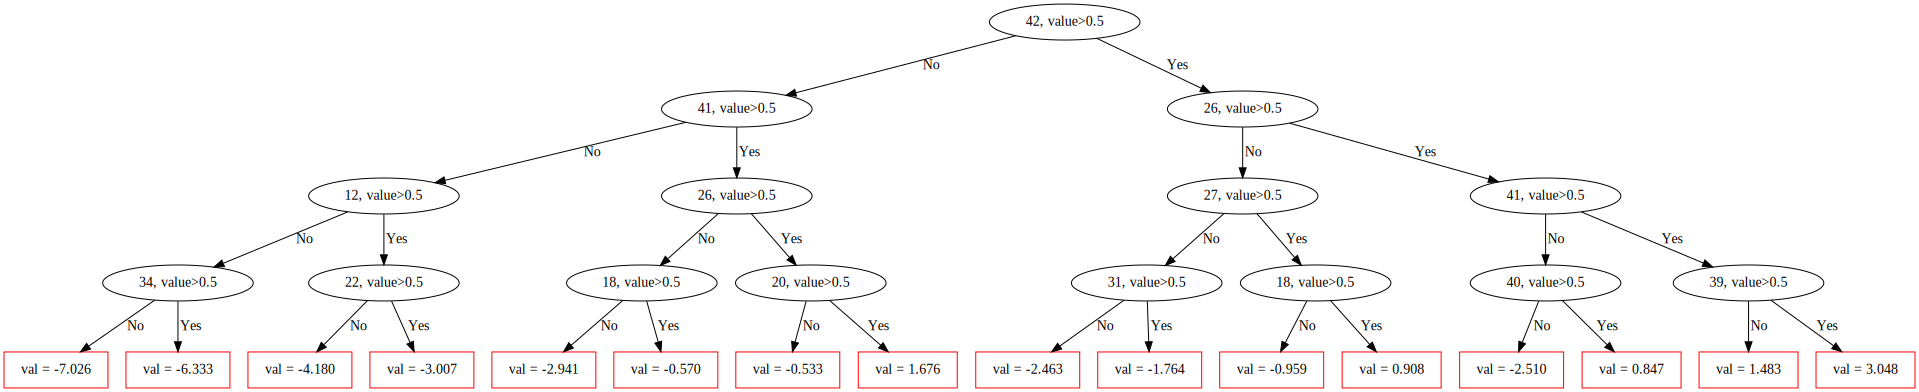

In [9]:
model.plot_tree(tree_idx = 0)

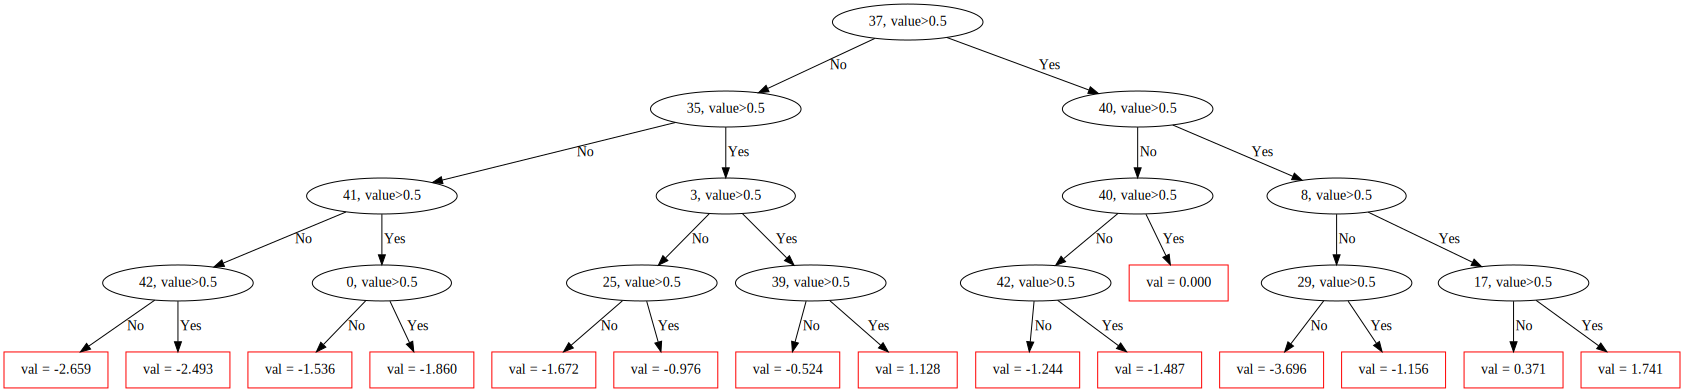

In [10]:
model.plot_tree(tree_idx = 1)

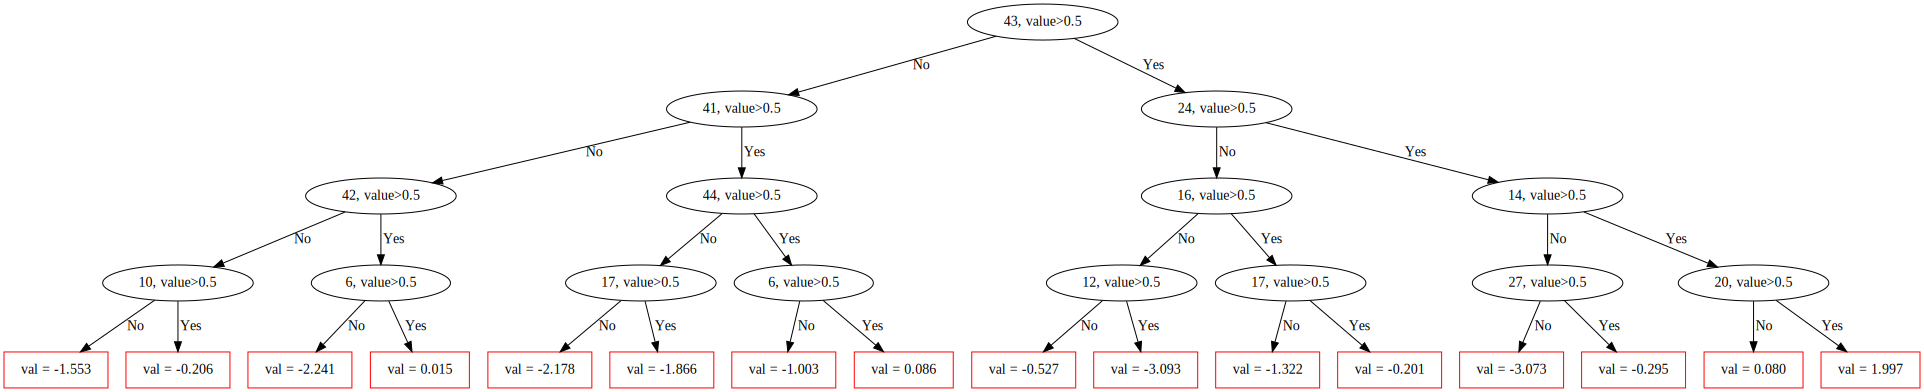

In [11]:
model.plot_tree(tree_idx = 2)